# Нелинейный SVM с трюком с ядром (Kernel Trick)

Демонстрация работы SVM с различными ядрами на датасете **Breast Cancer Wisconsin**.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from source.svm import SVM
from source.kernels import LinearKernel, PolynomialKernel, RBFKernel
from sklearn.metrics import accuracy_score
from source.vizualization import show_support_vectors

np.random.seed(42)


## 1. Загрузка и подготовка данных Breast Cancer Wisconsin


In [3]:
# Загрузка датасета
data = load_breast_cancer()
X, y = data.data, data.target

print(f"Датасет: {data.DESCR.split(chr(10))[0]}")
print(f"Размер данных: {X.shape}")
print(f"Признаки: {data.feature_names[:5]}... (всего {len(data.feature_names)})")
print(f"Классы: {data.target_names}")
print(f"Распределение классов: {np.bincount(y)}")


Датасет: .. _breast_cancer_dataset:
Размер данных: (569, 30)
Признаки: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']... (всего 30)
Классы: ['malignant' 'benign']
Распределение классов: [212 357]


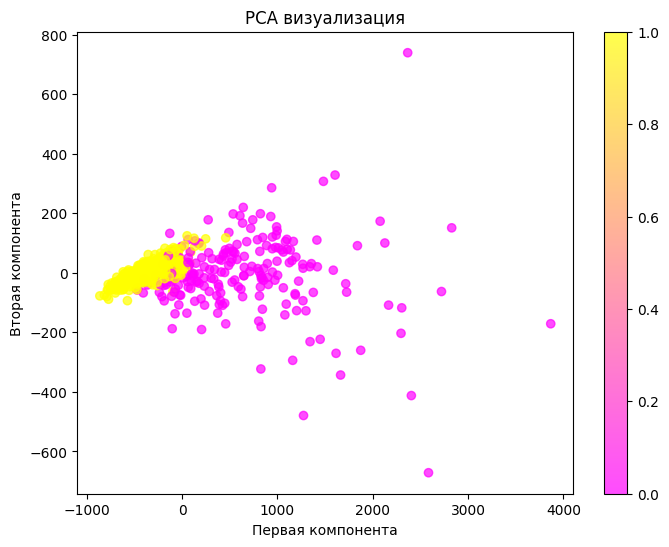

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='spring', alpha=0.7)
plt.colorbar()
plt.title('PCA визуализация')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.show()

In [5]:
# Разделение на train/test и нормализация
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Стандартизация признаков (важно для SVM!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Преобразуем метки: 0 (malignant) -> -1, 1 (benign) -> +1
y_train_svm = np.where(y_train == 0, -1, 1)
y_test_svm = np.where(y_test == 0, -1, 1)

print(f"Train: {X_train_scaled.shape[0]} samples")
print(f"Test: {X_test_scaled.shape[0]} samples")


Train: 398 samples
Test: 171 samples


## 2. Сравнение ядер


In [6]:
# Обучаем SVM с разными ядрами
kernels = {
    'Линейное': LinearKernel(),
    'Полиномиальное (d=2)': PolynomialKernel(degree=2, gamma=0.01, coef0=0.0),
    'Полиномиальное (d=3)': PolynomialKernel(degree=3, gamma=0.01, coef0=1.0),
    'RBF (γ=0.01)': RBFKernel(gamma=0.01),
    'RBF (γ=0.1)': RBFKernel(gamma=0.1),
    'RBF (γ=1.0)': RBFKernel(gamma=1.0),
}


results = []
support_vectors_indices = {}  # Сохраняем индексы опорных векторов для каждого ядра
trained_svms = {}  # Сохраняем обученные модели

print(f"{'Ядро':25s} | {'Train Accuracy':^15s} | {'Test Accuracy':^15s} | {'Опорные векторы':^15s}")
print(f"{'':-<25s}-+-{'':-^15s}-+-{'':-^15s}-+-{'':-^15s}")

for name, kernel in kernels.items():
    svm = SVM(C=1.0, kernel=kernel)
    svm.fit(X_train_scaled, y_train_svm)
    train_acc = accuracy_score(y_train_svm, svm.predict(X_train_scaled))
    test_acc = accuracy_score(y_test_svm, svm.predict(X_test_scaled))
    n_sv = svm.n_support_vectors
    
    # Сохраняем индексы опорных векторов (в train выборке)
    sv_indices = np.where(svm.alpha > svm.threshold)[0]
    support_vectors_indices[name] = sv_indices
    trained_svms[name] = svm
    
    results.append({
        'Ядро': name,
        'Train': f'{train_acc:.2%}',
        'Test': f'{test_acc:.2%}',
        'SV': n_sv
    })
    print(f"{name:25s} | {train_acc:^15.2%} | {test_acc:^15.2%} | {n_sv:^15d}")


Ядро                      | Train Accuracy  |  Test Accuracy  | Опорные векторы
--------------------------+-----------------+-----------------+----------------
Линейное                  |     98.99%      |     98.25%      |       31       
Полиномиальное (d=2)      |     75.38%      |     71.93%      |       259      
Полиномиальное (d=3)      |     97.74%      |     96.49%      |       62       
RBF (γ=0.01)              |     97.99%      |     96.49%      |       84       
RBF (γ=0.1)               |     98.49%      |     95.91%      |       173      
RBF (γ=1.0)               |     100.00%     |     62.57%      |       398      


## 3. Визуализация опорных векторов

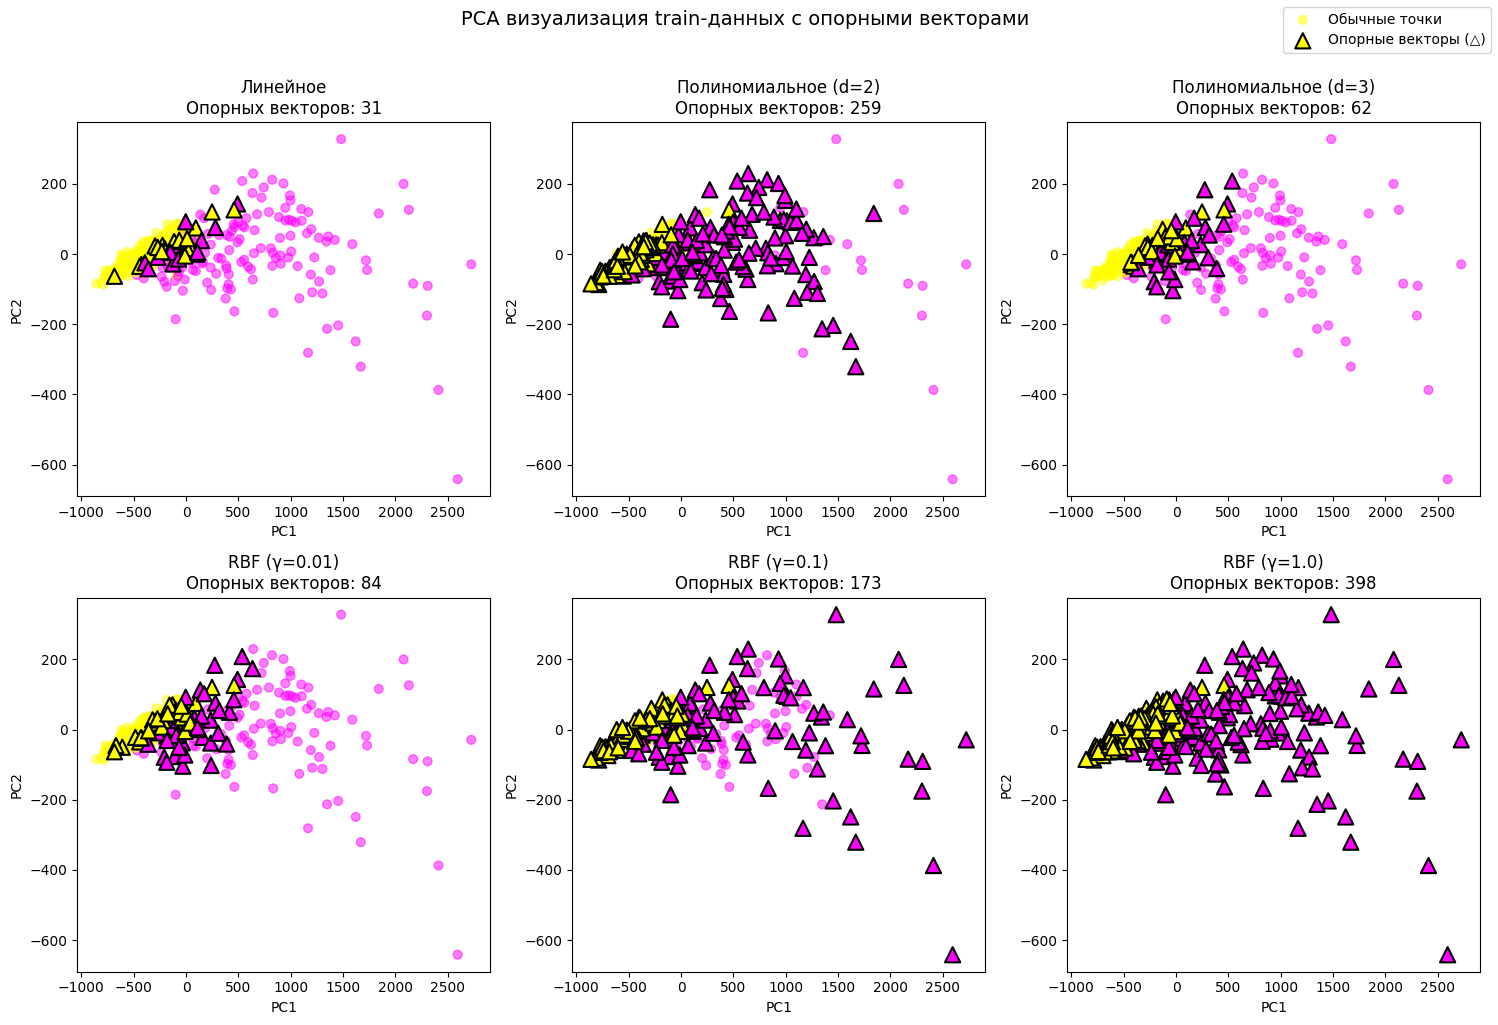

In [7]:
show_support_vectors(X_train, y_train, support_vectors_indices)


## 4. Сравнение с эталонной реализацией

In [8]:
# Сравнение с эталонной реализацией (sklearn) для линейного ядра
print("=" * 70)
print("Сравнение с sklearn SVC (линейное ядро)")
print("=" * 70)

# Обучаем sklearn SVC с линейным ядром
svc = SVC(C=1.0, kernel='linear')
svc.fit(X_train_scaled, y_train_svm)

sk_train_acc = accuracy_score(y_train_svm, svc.predict(X_train_scaled))
sk_test_acc = accuracy_score(y_test_svm, svc.predict(X_test_scaled))
sk_n_sv = sum(svc.n_support_)

# Получаем результаты кастомной реализации
custom_svm = trained_svms['Линейное']
custom_train_acc = accuracy_score(y_train_svm, custom_svm.predict(X_train_scaled))
custom_test_acc = accuracy_score(y_test_svm, custom_svm.predict(X_test_scaled))
custom_n_sv = custom_svm.n_support_vectors

print(f"\n{'Метрика':25s} | {'Кастомная SVM':^15s} | {'sklearn SVC':^15s}")
print(f"{'':-<25s}-+-{'':-^15s}-+-{'':-^15s}")
print(f"{'Train Accuracy':25s} | {custom_train_acc:^15.5%} | {sk_train_acc:^15.5%}")
print(f"{'Test Accuracy':25s} | {custom_test_acc:^15.5%} | {sk_test_acc:^15.5%}")
print(f"{'Опорные векторы':25s} | {custom_n_sv:^15d} | {sk_n_sv:^15d}")


Сравнение с sklearn SVC (линейное ядро)

Метрика                   |  Кастомная SVM  |   sklearn SVC  
--------------------------+-----------------+----------------
Train Accuracy            |    98.99497%    |    98.99497%   
Test Accuracy             |    98.24561%    |    98.24561%   
Опорные векторы           |       31        |       31       
